In [1]:
%env TF_CPP_MIN_LOG_LEVEL=3
import sys
from dataclasses import dataclass
import random as r
from functools import partial
from matplotlib import pyplot as plt

import jax
from jax import Array, numpy as jnp, random as jrand
import keras as nn
nn.utils.set_random_seed(42); nn.mixed_precision.set_dtype_policy("mixed_float16")
import tensorflow as tf; tf.config.set_visible_devices([], 'GPU')
tf.random.set_seed(42)

print("Python Version", sys.version); del sys
print(f"Keras Version {nn.__version__} with {nn.backend.backend()} backend \tJax Version {jax.__version__}")
print("Jax backend device", jax.default_backend())

env: TF_CPP_MIN_LOG_LEVEL=3
Python Version 3.11.8 (main, Feb 25 2024, 16:39:33) [GCC 11.4.0]
Keras Version 3.0.4 with jax backend 	Jax Version 0.4.23
Jax backend device gpu


# Positional Embeddings

In [2]:
class PositionalEmbedding:
    """```
    Sinusoidal Fixed Positional Embeddings
    Args:
        maxlen:int
        dim:int
    sinusoidal_embeddings: 
        pos_emb: (1, maxlen, dim)
    get_freqs:
        get_freqs: sin_freqs(1, maxlen, 1, dim), cos_freqs(1, maxlen, 1, dim)
    ```"""
    def __init__(self, maxlen:int, dim:int):
        p, i = jnp.meshgrid(jnp.arange(float(maxlen)), jnp.arange(dim/2)*2)
        theta = (p/1e4**(i/dim)).T

        self.pos_emb = jnp.stack([jnp.sin(theta), jnp.cos(theta)], axis=-1)
        self.pos_emb = self.pos_emb.reshape((maxlen, dim))[None] # (1, maxlen, dim)

    def sinusoidal_embeddings(self):
        return self.pos_emb # (1, maxlen, dim)
    
    def get_freqs(self):
        sin_freqs = jnp.repeat(self.pos_emb[..., None, ::2], repeats=2, axis=-1)
        cos_freqs = jnp.repeat(self.pos_emb[..., None, 1::2], repeats=2, axis=-1)
        return sin_freqs, cos_freqs # (1, maxlen, 1, dim), (1, maxlen, 1, dim)

# Attention

In [3]:
class Attention(nn.Layer):
    """```
    Multi-head Attention
    Args:
        causal:bool
        n_heads:int
        d_model:int
        maxlen:int
        dropout_rate:float
    Input:
        x: shape(B, N, d_model)
    Output:
        linear_att_out: shape(B, N, d_model)
    ```"""
    def __init__(
            self,
            causal:bool,
            num_heads:int,
            d_model:int,
            maxlen:int,
            dropout_rate:float,
            **kwargs
    ):
        super().__init__(**kwargs)
        assert d_model % num_heads == 0
        self.causal = causal
        self.num_heads = num_heads
        self.d_model = d_model
        self.dim = self.d_model//num_heads

        self.wq = nn.layers.Dense(self.d_model, use_bias=False)
        self.wk = nn.layers.Dense(self.d_model, use_bias=False)
        self.wv = nn.layers.Dense(self.d_model, use_bias=False)
        self.attwei_dropout = nn.layers.Dropout(dropout_rate)

        self.w = nn.layers.Dense(d_model)
        if causal:
            self.causal_mask = jnp.triu(jnp.full(shape=(1, 1, maxlen, maxlen), fill_value=-jnp.inf), k=1)

    def call(
            self,
            x:Array, # (B, T, d_model)
            training:bool
    ):
        B, T = x.shape[:-1]

        # compute q, k, v
        q = self.wq(x) # (B, T, d_model)
        k = self.wk(x) # (B, T, d_model)
        v = self.wv(x) # (B, T, d_model)

        # seperate heads
        q = q.reshape((B, self.num_heads, T, self.dim)) # (B, h, T, dim)
        k = k.reshape((B, self.num_heads, T, self.dim)) # (B, h, T, dim)
        v = v.reshape((B, self.num_heads, T, self.dim)) # (B, h, T, dim)

        # compute attention weights
        att_wei = (q @ k.transpose((0, 1, 3, 2)))/self.dim**0.5 # (B, h, T, T) <= (B, h, T, dim) @ (B, h, T, dim).transpose(2, 3)
        if self.causal:
            att_wei = att_wei + self.causal_mask[:, :, :T, :T] # (B, h, T, T)

        att_wei = jax.nn.softmax(att_wei, axis=-1) # (B, h, T, T)
        att_wei = self.attwei_dropout(att_wei, training=training)

        # apply attention weights to v
        att_out = att_wei @ v # (B, h, T, T) @ (B, h, T, dv) => (B, h, T, dv)
        # combine heads
        att_out = att_out.reshape((B, T, self.d_model)) # (B, T, h*dv) ==> (B, T, d_model)

        # linear of att_out
        linear_att_out = self.w(att_out) # (B, T, d_model)
        return linear_att_out

# GPT

In [4]:
def build_model(model:nn.Model, input_shape:tuple, val_intervals:tuple):
    blabla = model(
        jrand.randint(jrand.PRNGKey(32344), shape=input_shape, minval=val_intervals[0], maxval=val_intervals[-1]), training=True
    ); del blabla
    return model


class TieWeights(nn.Layer):
    def __init__(self, dense:nn.Layer, output_units:int,  activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense # (1, vocab_size, d_model)
        self.activation = nn.layers.Activation(nn.activations.get(activation), dtype=kwargs["dtype"])
        self.bias = self.add_weight(shape=(output_units,), initializer="zeros", trainable=True)
        
    def call(self, x): # (B, T, d_model)
        W = jnp.array(self.dense.weights)[0].T # (d_model, vocab_size)
        return self.activation(x @ W + self.bias)


class Block(nn.Model):
    """```
    Block
    Args:
        causal:bool
        num_heads:int
        d_model:int
        maxlen:int
        dropout_rate:float
        use_bias:bool
    Inputs: 
        inputs: shape(B, T, d_model)
        pad_mask: shape(B, T) of boolean dtype
    Outputs:
        outputs: shape(B, T, d_model)
    ```"""
    def __init__(
            self, 
            causal: bool, 
            num_heads: int, 
            d_model: int,
            maxlen:int,
            dropout_rate: float,
            **kwargs
    ):
        super().__init__(**kwargs)
        dff_in = 4*d_model
        self.norm1 = nn.layers.LayerNormalization(epsilon=1e-5)
        self.norm2 = nn.layers.LayerNormalization(epsilon=1e-5)

        self.mha = Attention(causal, num_heads, d_model, maxlen, dropout_rate)

        self.ffn = nn.Sequential([
            nn.layers.Dense(int(dff_in), use_bias=True),
            nn.layers.Activation(nn.activations.gelu),
            nn.layers.Dense(d_model, use_bias=True),
            nn.layers.Dropout(dropout_rate)
        ])
        
    def call(self, x:Array, training:bool):
        z = x + self.mha(self.norm1(x), training=training)
        y = z + self.ffn(self.norm2(z), training=training)
        return y # (B, T, d_model)

In [5]:
class GPT(nn.Model):
    """```
    GPT!!
    Args:
        args:
            d_model: int
            num_heads: int
            num_layers: int
            max_context_length: int
            vocab_size: int
            output_units: int => if None is equal to vocab_size
            dropout_rate: float
        causal:bool
        output_activation:str
    Inputs:
        inputs: shape(B, T)
    Outputs: 
        outputs: shape(B, T, d_model)    
    ```"""
    def __init__(self, args, causal:bool, output_activation:str=None, **kwargs):
        super().__init__(**kwargs)
        if args.output_units is None:
            args.output_units = args.vocab_size
        # pos embedding
        self.pos_embed = PositionalEmbedding(args.max_context_length, args.d_model).sinusoidal_embeddings() # (1, maxlen, d_model)
        # embedding tokens and dropout
        self.emb_dropout = nn.layers.Dropout(args.dropout_rate)
        self.token_embed = nn.layers.Embedding(args.vocab_size, args.d_model)

        # block layers
        self.block_layers = [
                Block(
                    causal=causal, 
                    num_heads=args.num_heads,
                    d_model=args.d_model,
                    maxlen=args.max_context_length,
                    dropout_rate=args.dropout_rate,
                ) for _ in range(args.num_layers)
            ]

        # final layer: outputs logits with dropout
        self.norm = nn.layers.LayerNormalization(epsilon=1e-5)
            # nn.layers.Dense(args.output_units, activation=output_activation, use_bias=True)
        self.linear = TieWeights(self.token_embed, args.output_units, activation=output_activation, dtype="float32")
        self.logits_dropout = nn.layers.Dropout(rate=args.dropout_rate)

    def call(
            self, 
            inputs:Array,
            training=False
    ):
        # embed tokens
        x = self.emb_dropout(
            self.token_embed(inputs)+self.pos_embed[:, :inputs.shape[-1], :], training=training
        ) # (B, T) ==> (B, T, d_model) # (B, T) ==> (B, T, d_model)
        
        # block layers
        for layer in self.block_layers:
            x = layer(x, training=training) # (B, T, d_model) ==> (B, T, d_model)
        x = self.norm(x)

        # linear layer: outputs logits
        logits = self.linear(x) # (B, T, d_model) ==> (B, T, vocab_size)
        return self.logits_dropout(logits)

# Dataset

In [6]:
shakespeare_url = "https://homl.info/shakespeare"
filepath = nn.utils.get_file("shakespeare.txt", shakespeare_url)
shakespeare_text = open(filepath, "r", encoding="utf-8").read()

In [7]:
print(shakespeare_text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [8]:
chars = sorted(list(set(shakespeare_text)))
VOCAB_SIZE = len(chars)
print(''.join(chars))
print(VOCAB_SIZE)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [9]:
def to_dataset(sequence, length, shuffle=False, seed=None, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window_ds: window_ds.batch(length + 1))
    if shuffle:
        ds = ds.shuffle(1_000_000, seed=seed)
    ds = ds.batch(batch_size)
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

In [10]:
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

print(encode(shakespeare_text[:100]))
print(decode(encode(shakespeare_text[:100])))

[18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 14, 43, 44, 53, 56, 43, 1, 61, 43, 1, 54, 56, 53, 41, 43, 43, 42, 1, 39, 52, 63, 1, 44, 59, 56, 58, 46, 43, 56, 6, 1, 46, 43, 39, 56, 1, 51, 43, 1, 57, 54, 43, 39, 49, 8, 0, 0, 13, 50, 50, 10, 0, 31, 54, 43, 39, 49, 6, 1, 57, 54, 43, 39, 49, 8, 0, 0, 18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 37, 53, 59]
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


# GPT Args

In [11]:
@dataclass
class GPTArgs:
    """GPT Configuration"""
    d_model:int = 288
    num_layers:int = 6
    num_heads:int = 6
    max_context_length:int = 256
    vocab_size:int = VOCAB_SIZE
    output_units:int = None
    assert d_model % 2 == 0
    assert d_model % num_heads == 0
    dropout_rate:float = 0.3125

GPTArgs()

GPTArgs(d_model=288, num_layers=6, num_heads=6, max_context_length=256, vocab_size=65, output_units=None, dropout_rate=0.3125)

In [12]:
model = GPT(GPTArgs, causal=True)
model = build_model(model, (2, GPTArgs.max_context_length), [0, GPTArgs.vocab_size-1])
model.summary()

Model: "gpt"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dropout (Dropout)               │ ?                         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ embedding (Embedding)           │ ?                         │     18,720 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block (Block)                   │ ?                         │    998,208 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block_1 (Block)                 │ ?                         │    998,208 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block_2 (Block)                 │ ?                         │    998,208 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block_3 (Block)                 │ ?                         │    998,208 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block_4 (Block)                 │ ?                         │    998,208 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block_5 (Block)                 │ ?                         │    998,208 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ layer_normalization_12          │ ?                         │        576 │
│ (LayerNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ tie_weights (TieWeights)        │ ?                         │     18,785 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_13 (Dropout)            │ ?                         │          0 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 6,008,609 (22.92 MB)

 Trainable params: 6,008,609 (22.92 MB)

 Non-trainable params: 0 (0.00 B)

# Loss Vs LR

```python
def LossvsLR(): # (B, maxlen)
    model = build_model(
        GPT(GPTArgs, causal=True, ), 
        (2, GPTArgs.max_context_length), 
        (0, GPTArgs.vocab_size-1)
        )
    inputs = jrand.randint(jrand.PRNGKey(32344), shape=(2, GPTArgs.max_context_length+1), minval=0, maxval=GPTArgs.vocab_size-1)

    def get_loss(lr, model, inputs):
        x, y = inputs[:, :-1], inputs[:, 1:]
        model.compile(
            optimizer=nn.optimizers.AdamW(
                learning_rate=lr, beta_1=0.9, beta_2=0.99, clipvalue=1e0, weight_decay=1e-1),
            loss=nn.losses.SparseCategoricalCrossentropy(from_logits=True)
        )
        loss = model.train_on_batch(x=x, y=y)
        return loss.tolist()
    
    lrs = (10**jnp.linspace(-6, -2, 100)).tolist()
    losses = [get_loss(lr, model, inputs) for lr in lrs]
    # losses = jax.vmap(get_loss, in_axes=(None, 0))(model, lrs)
    return lrs, losses

lr, loss = LossvsLR()

plt.figure(figsize=(15,10))
plt.xlabel("Learning Rate: 10^(x) to get actual learning rate")
plt.ylabel("Loss")
plt.xticks([-6, -5, -4]+jnp.arange(-3.5, -2.8, 0.1).tolist())
plt.plot(jnp.log10(jnp.array(lr)), loss)
plt.show()
```

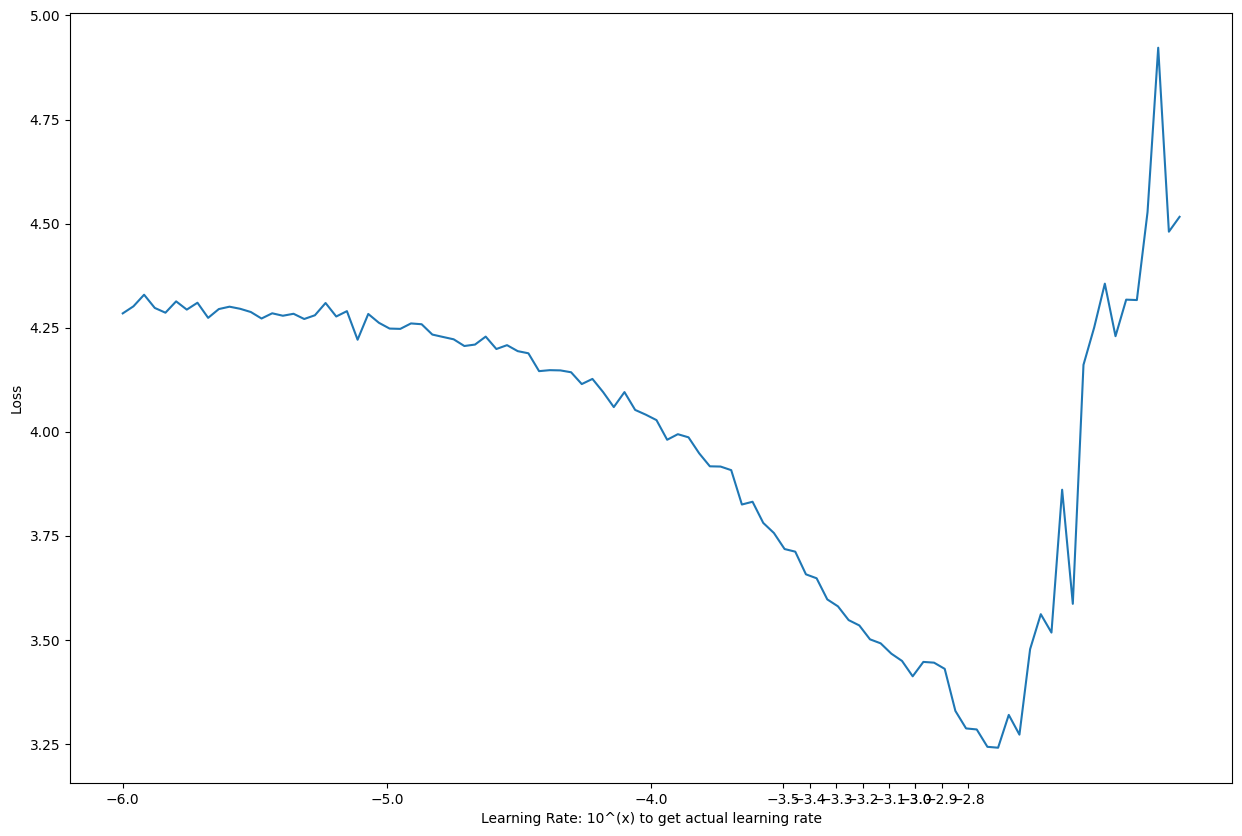

# Training Arguments

In [13]:
@dataclass
class TArgs:
    "Training Arguments"
    steps_per_epoch:int = 250
    patience:int = 10
    
    batch_size:int = 128
    num_steps:int = 5000
    epochs:int = num_steps//steps_per_epoch

    init_lr:float = 1e-7
    max_lr:float = 8.5e-4
    min_lr:float = 0.1*max_lr
    warmup_steps:int = 150
    decay_steps:int = num_steps

    beta1:float = 0.9
    beta2:float = 0.99
    clipvalue:float = 1e0
    weight_decay:float = 1e-1

In [14]:
data = encode(shakespeare_text)
datasets = {"train": to_dataset(data[:1_000_000], length=GPTArgs.max_context_length, shuffle=True, batch_size=TArgs.batch_size, seed=42).repeat(5).shuffle(10000), # ~90%split
            "val": to_dataset(data[1_000_000:], length=GPTArgs.max_context_length, shuffle=True, batch_size=TArgs.batch_size, seed=0)}
print(datasets)

{'train': <_ShuffleDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None))>, 'val': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None))>}


# Model, lr schedule, compile and training

In [15]:
learning_rate = nn.optimizers.schedules.CosineDecay(
    initial_learning_rate=TArgs.min_lr,
    decay_steps=TArgs.decay_steps,
    warmup_steps=TArgs.warmup_steps,
    warmup_target=TArgs.max_lr,
    alpha=TArgs.min_lr/TArgs.max_lr
)

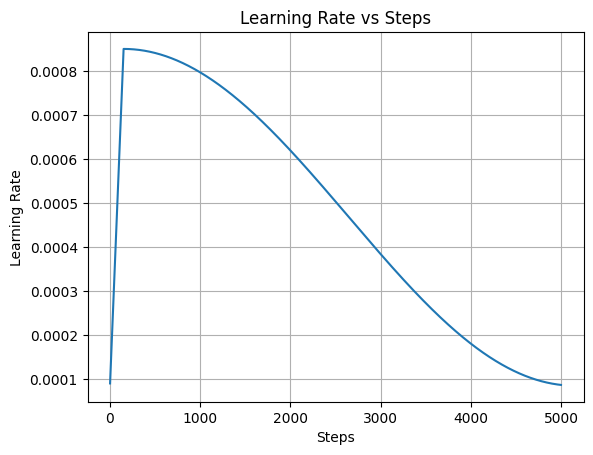

In [16]:
steps = jnp.arange(1, TArgs.num_steps+1)
lrs = jax.vmap(learning_rate)(steps)

plt.plot(steps, lrs); del lrs, steps
plt.grid(True)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate vs Steps")
plt.show()

In [17]:
model.compile(
    optimizer=nn.optimizers.AdamW(
        learning_rate=learning_rate,
        beta_1=TArgs.beta1,
        beta_2=TArgs.beta2, 
        clipvalue=TArgs.clipvalue, 
        weight_decay=TArgs.weight_decay,
    ),
    loss=nn.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics="accuracy"
)

In [18]:
early_stop = nn.callbacks.EarlyStopping(
    patience=TArgs.patience,
    restore_best_weights=True,
    verbose=1
)

In [19]:
history = model.fit(
    x=datasets["train"],
    epochs=TArgs.epochs,
    steps_per_epoch=TArgs.steps_per_epoch,
    validation_data=datasets["val"],
    callbacks=[early_stop]
) # 15mins

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 165ms/step - loss: 3.3976 - val_loss: 3.0993
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 153ms/step - loss: 2.6779 - val_loss: 2.1405
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 156ms/step - loss: 2.0795 - val_loss: 1.8481
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 157ms/step - loss: 1.7536 - val_loss: 1.7281
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 161ms/step - loss: 1.5947 - val_loss: 1.6585
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 154ms/step - loss: 1.5096 - val_loss: 1.6146
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 156ms/step - loss: 1.4525 - val_loss: 1.5771
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 155ms/step - loss: 1.4121 - val_loss: 1.5519
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 154ms/step - loss: 1.3783 - val_loss: 1.5378
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 155ms/step - loss: 1.3498 - val_loss: 1.5239
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 157ms/step - loss: 1.3294 - val_loss: 1.5177
Epoch 12/20
250/250

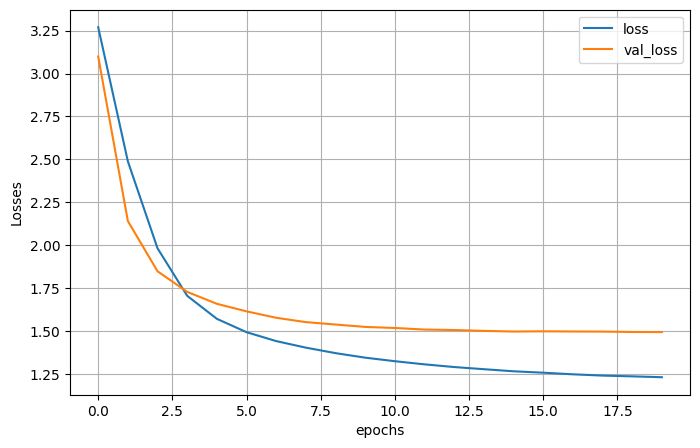

In [20]:
from pandas import DataFrame
df = DataFrame({key:value for key, value in history.history.items() if key in ["loss", "val_loss"]})
df.plot(figsize=(8, 5), grid=True, xlabel="epochs", ylabel="Losses");

# Generate Predictions

In [21]:
def sample_top_k(key, logits, k):
    topk_logits, topk_idx = jax.lax.top_k(logits, k=k)
    idx = jrand.categorical(key, topk_logits)
    return topk_idx[0][idx]

def generate(idx:Array, max_new_tokens:int, top_k:int|None=None, seed:int=42):    
    key = jrand.PRNGKey(seed)
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -GPTArgs.max_context_length:] # (B, T)
        logits = model(idx_cond, training=False)[:, -1, :]/0.8 # (B, T, vocab_size)[:, -1, :] => (B, vocab_size)
        idx_next = jrand.categorical(key, logits) if top_k is None else sample_top_k(key, logits, k=top_k) # (T=1,)
        key, _ = jrand.split(key)
        idx = jnp.concatenate((idx, idx_next[None]), axis=-1) # (B, T+1)
    return idx.tolist()[0]

In [22]:
print(decode(generate(idx=jnp.array([[0]]), max_new_tokens=4000, seed=42, top_k=None))) # random categorical sampling # ~12.5mins


S:
I shalo,
Ready
That, to run?
No, ind his thought on the time,
Edward fon's in just, mirane!
Thy word you would not let thyself,
Tome s, welie out tlime; still but sing.

GLOUCEOMEY:
WIOLIOLENERE:
No, no, no:
I help theavearelelis pt ncanowilime, truly.

GLOUCESTER:
But I did, sir, full man the tept of them!

CORIOLANUS:
I swift!

Second Servingman:
When we will let me go to, that he shall satisfy
My beards with an earthly commanded here,
That would wish your painted in this right.

MONTAGUE:
And I heard thee now well see, I pray you,
And you must be a good thing: I'll indeed to revenge
The time of the way: and he had him so born
Shall be satisfied.

Second Citizen:
Let them blessed by the day to use of it?

Nurse:
Come, for I have said 'Ay,' quoth his father.

Second Servingman:
The ground of Claudio take thee to his country:
And ere I did confess too, my words is full as
some from night once with your grace for your contract,
So think his face have turns the liberty.

AUTOLYCUS:
T

In [23]:
print(decode(generate(idx=jnp.array([[0]]), max_new_tokens=4000, seed=98857745, top_k=10))) # tok-10 random categorical sampling # ~7mins


INIUSTANUS:
And the mine of this
that all postern
Than thou wouldst speak,
That at wouldst ainguster
Than any of his brother.
What as we'thoullll, he shall
In who do it that see tamididiske,
Ulide, his foe statutes, that wane tine,
We aline, ale te's all sense, who having them for
their carries strength against the strength of the discourse.

QUEEN ELIZABETH:
To the parties of the diam, which is the world
Of this patient will dispatch to your lives;
And by the honour, sir, sir, and tell him that
the contrary.

LUCIO:
Tranio; what is it went thy have hand to beat
With the head of complexion in the ghild and
to be accused, and shake off his life
Is this the country that my love, some masks
Having the worst and love the tongue-tended sun,
That thou art not full in his head with the baseness,
Which we have made me amazed her found,
If you be so be more find than the world shall
Depose against the prince's place.

LADY CAPULET:
And I, an as it pass'd thee with her blood,
I have deserved ag

In [24]:
print(decode(generate(idx=jnp.array([[0]]), max_new_tokens=4000, seed=12212, top_k=5))) # tok-5 random categorical sampling # ~7mins


INIUShaps fest.

CLARET:
No, I hope:
And so things in the best
Of my bands! I
Hathink shist stheat in the prophecy blood,
Till he thath beathis I, hary sir.

LADY GREY:
No, the'sonot we'se'so hee in, that
it is my thatem se canore hore, telimopa the,
That to my soul soul as I have been so fearful
Is some storms and the crown. If I deserve
I have too lately do this were the first:
The bastardy of him.

MENENIUS:
I will be thine own babe:
I will not proclaim the court.

PETRUCHIO:
I am a woman from the city while he doth thee
To make a mean to the parliament.

Second Citizen:
Will I not but still and men, we will back and carried
To see their soul, that still set upon their hands.

DUKE VINCENTIO:
I were they do beseech you, sir, to my sin,
Will you serve to him and here.

Provost:
And so, sir, would have half as you are.

CORIOLANUS:
Worthy Capitol;
Within what you will not step him as any
Thing that the moon of the world. He that do not
Think him for that way her father were this fear

In [25]:
print(decode(generate(idx=jnp.array([[0]]), max_new_tokens=4000, seed=4357, top_k=25))) # tok-7 random categorical sampling # ~7.5mins


S:
Ar,
O, al
That your wife all tie for hear these
Would not have turns wear with
There din meshuts the returns of the
sight of athermie; talin,
I shas the time will manife.

LADYe Thonge, Ly Rinora is a good man
Which wilest peramones afufufulinits.

WARWICK:
This is our father's brother for me how to-night.

KING RICHARD II:
My lord, I am court in this land to joy
By the hand changed about the end of a woman's
wears to be heard my follower makes me this winter's strength,
Which she breaks the traitor to the content.

POLIXENES:
You are but present art all famous,
How far being but we will give a man thoughts are
To enjoy the like that born to each in pain;
And shame the end of heavy and proof,
To what I request you the imagined
With all as full of prayers than he is distemper'd,
To sound me with him, which you meet the sun.

Second Servant:
The whoo's the heavily of this land that was
I never live, surely not send to see this proclaim
The sin her soul to make us a woman's wit.

LEON

In [26]:
print(decode(generate(idx=jnp.array([[0]]), max_new_tokens=4000, seed=2354732, top_k=45))) # tok-45 random categorical sampling # ~6.5mins


Cour:
Sir,
Lament;
Ay, that heavens
With heir with ones,
And so thine own,
To see a weearilid ong-tale; ther
shalles,
That way in fre slobe lecre?
Ysed be approacure cap to theachee,
ptedirralle. on't with his complisonous
Is don's, ats, at t foryie; crave your highness' looks,
And begin to him say and less in the chair
And all the sun shall be plain'd his tift?

First Senator:
What, the babe of hate, sir: the great of fourteen shall
not speak in proudless both to sight and fright in
The king of curtains, speak to the field,
Or when I have been things natural.

MENENIUS:
He that name is mad?

CLARENCE:
All things remosts, and since he hath strong may
For my provost! You will revenge before I did considered.

KING EDWARD IV:
For I have stuff'd from my heads miscarried;
And so should have you goes to bed.

ROMEO:
Why, if you will devote beholding him still,
Brave Forth, the other for Romeo slaughter'd
The other sights to be into the son.
My part the father with fury in my head.

DUKE VI

In [28]:
print(decode(generate(idx=jnp.array([[0]]), max_new_tokens=2000, seed=2354732, top_k=1))) # Greedy Sampling: bad # ~3.716666667mins





LARABET:
And the
shall bear
The senat.

COMINIUS:
I will not so.

CORIOLANUS:
Why, thathallilt the world in there was not,
And there thowithering t the
shepher shalling stary ary fe te,
Tay tes tears and the, that wings anorange, anoraniraralining
That thou hast not so sound as the sea
As thou art the state of the sea of the state,
And therefore the world be so far as they shall
The sea to the prince of the sea of the state,
And therefore the world be so far as they shall
The sea to the prince of the sea of the state,
And therefore the world be so far as they shall
The sea to the prince of the sea of the state,
And therefore the world be so far as they shall
The sea to the prince of the sea of the state,
And therefore the world be so far as they shall
The sea to the prince of the sea of the state,
And therefore the world be so far as they shall
The sea to the prince of the sea of the state,
And therefore the world be so far as they shall
The sea to the prince of the sea of the stat